In [30]:
import numpy as np
import pandas as pd
from os.path import join, dirname, basename
from tqdm import tqdm
import os
import torch

In [31]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
def sub2adni(sub):
    return 'sub-ADNI'+''.join(sub.split('_'))

In [3]:
subs = np.loadtxt('SNP/samples.txt', dtype=str)
subs = np.array(list(map(sub2adni, subs)))

In [4]:
df = pd.read_csv('ADNI_CAPS/split.stratified.0.csv')
tmp = df[df['participant_id'].isin(subs)]
tmp = tmp.sort_values(by=['session_id'], ascending=False)
tmp = tmp.drop_duplicates(subset=['participant_id'])
df_snp = tmp.reset_index(drop=True)

In [5]:
def df2path(df, i):
    return join('saliency_map', df.split.iloc[i], df.participant_id.iloc[i], df.session_id.iloc[i]+'.npy')

In [6]:
paths = [df2path(df_snp, i) for i in range(len(df_snp))]
# np.save('snp_paths.npy', paths)

In [7]:
train_df = pd.read_csv('saliency_map/train_sailency_info.csv')
test_df = pd.read_csv('saliency_map/test_sailency_info.csv')
val_df = pd.read_csv('saliency_map/val_sailency_info.csv')
df_pred = pd.concat([train_df, test_df, val_df])
df_pred = df_pred.reset_index(drop=True)

In [8]:
df_snp = df_snp.merge(df_pred, how='inner', on=['participant_id', 'session_id'])
df_snp['diagnosis_pred'] = df_snp['prob_AD'].map(lambda x: np.round(x))

snp_correct = df_snp['diagnosis_y'] == df_snp['diagnosis_pred'].map(lambda x: int(x))
df_snp_correct = df_snp[snp_correct]

In [9]:
correct_paths = [df2path(df_snp_correct, i) for i in range(len(df_snp_correct))]

In [96]:
correct_paths

['saliency_map/train/sub-ADNI021S0337/ses-M96.npy',
 'saliency_map/train/sub-ADNI099S0352/ses-M96.npy',
 'saliency_map/train/sub-ADNI027S0074/ses-M96.npy',
 'saliency_map/val/sub-ADNI035S0555/ses-M96.npy',
 'saliency_map/val/sub-ADNI023S0331/ses-M96.npy',
 'saliency_map/train/sub-ADNI072S0315/ses-M96.npy',
 'saliency_map/test/sub-ADNI035S0292/ses-M96.npy',
 'saliency_map/train/sub-ADNI018S0142/ses-M96.npy',
 'saliency_map/train/sub-ADNI033S0923/ses-M96.npy',
 'saliency_map/train/sub-ADNI023S0042/ses-M96.npy',
 'saliency_map/val/sub-ADNI033S1016/ses-M96.npy',
 'saliency_map/train/sub-ADNI005S0553/ses-M96.npy',
 'saliency_map/train/sub-ADNI027S0120/ses-M96.npy',
 'saliency_map/val/sub-ADNI033S0920/ses-M96.npy',
 'saliency_map/train/sub-ADNI128S0272/ses-M96.npy',
 'saliency_map/train/sub-ADNI127S0925/ses-M96.npy',
 'saliency_map/train/sub-ADNI128S0229/ses-M96.npy',
 'saliency_map/train/sub-ADNI127S0259/ses-M96.npy',
 'saliency_map/train/sub-ADNI128S0227/ses-M96.npy',
 'saliency_map/train/

In [98]:
n = len(df_snp_correct)
dist = np.zeros((n, n))
for i in tqdm(range(n)):
    vi = np.load(correct_paths[i]).flatten()
    for j in range(i+1, n):
        vj = np.load(correct_paths[j]).flatten()
        dist[i][j] = np.linalg.norm(vi-vj)


100%|██████████| 195/195 [03:25<00:00,  1.05s/it]

In [99]:
np.save('raw_dist.npy', dist)

In [42]:
dist = np.load('raw_dist.npy')

In [101]:
dist.shape

(195, 195)

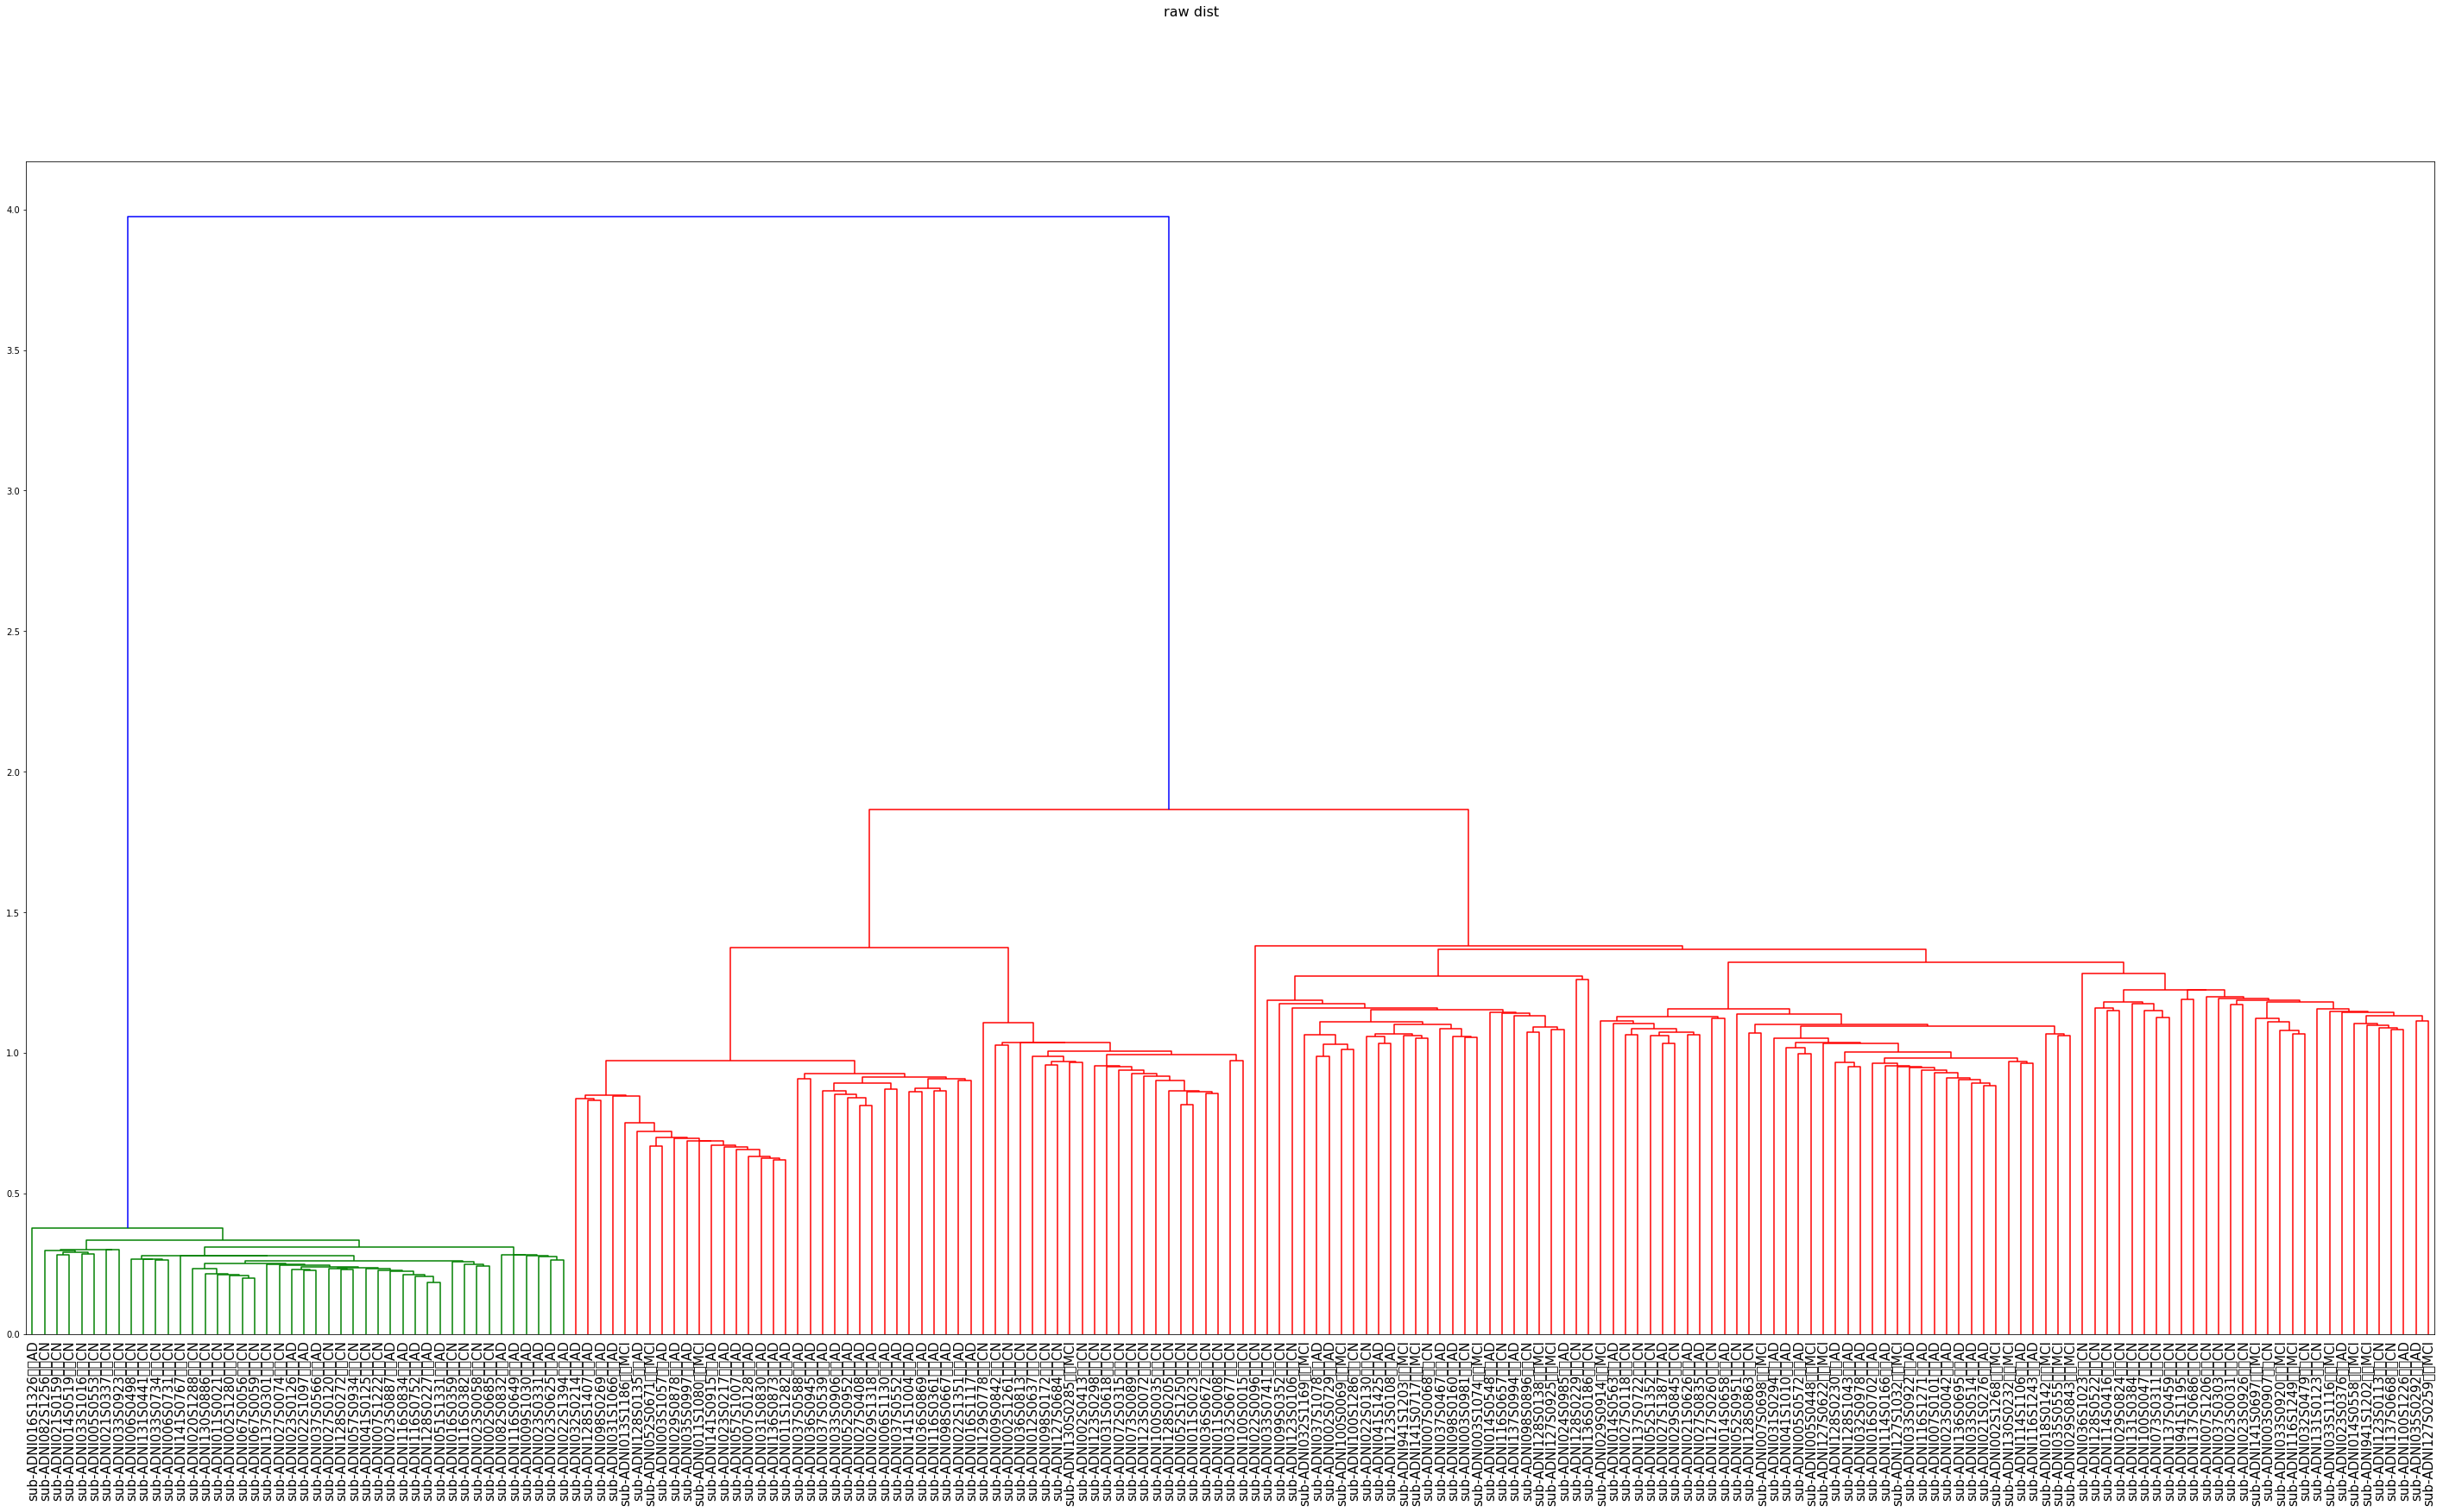

In [44]:
i, j = np.triu_indices(dist.shape[0], k=1)
X = dist[i, j]
labels = [df_snp_correct.participant_id.iloc[i]+'\t\t'+df_snp_correct.diagnosis_x.iloc[i] for i in range(len(df_snp_correct))]
Z = linkage(X, 'ward')
fig = plt.figure(figsize=(50, 25))
dn = dendrogram(Z, labels=labels, leaf_font_size=15)
fig.suptitle('raw dist', fontsize=16)
fig.savefig('raw.pdf')

In [108]:
def thresholding(x, r):
    thres = np.quantile(x, r)
    return x*(x>thres)

In [109]:
n = len(df_snp_correct)
thres_dist = np.zeros((n, n))
r = 0.95
for i in tqdm(range(n)):
    vi = thresholding(np.load(correct_paths[i]), r).flatten()
    for j in range(i+1, n):
        vj = thresholding(np.load(correct_paths[j]), r).flatten()
        thres_dist[i][j] = np.linalg.norm(vi-vj)


100%|██████████| 195/195 [20:10<00:00,  6.21s/it]

In [110]:
np.save('thresholding_0.95.npz', thres_dist)

thres_dist = np.load('thresholding_0.95.npz.npy')

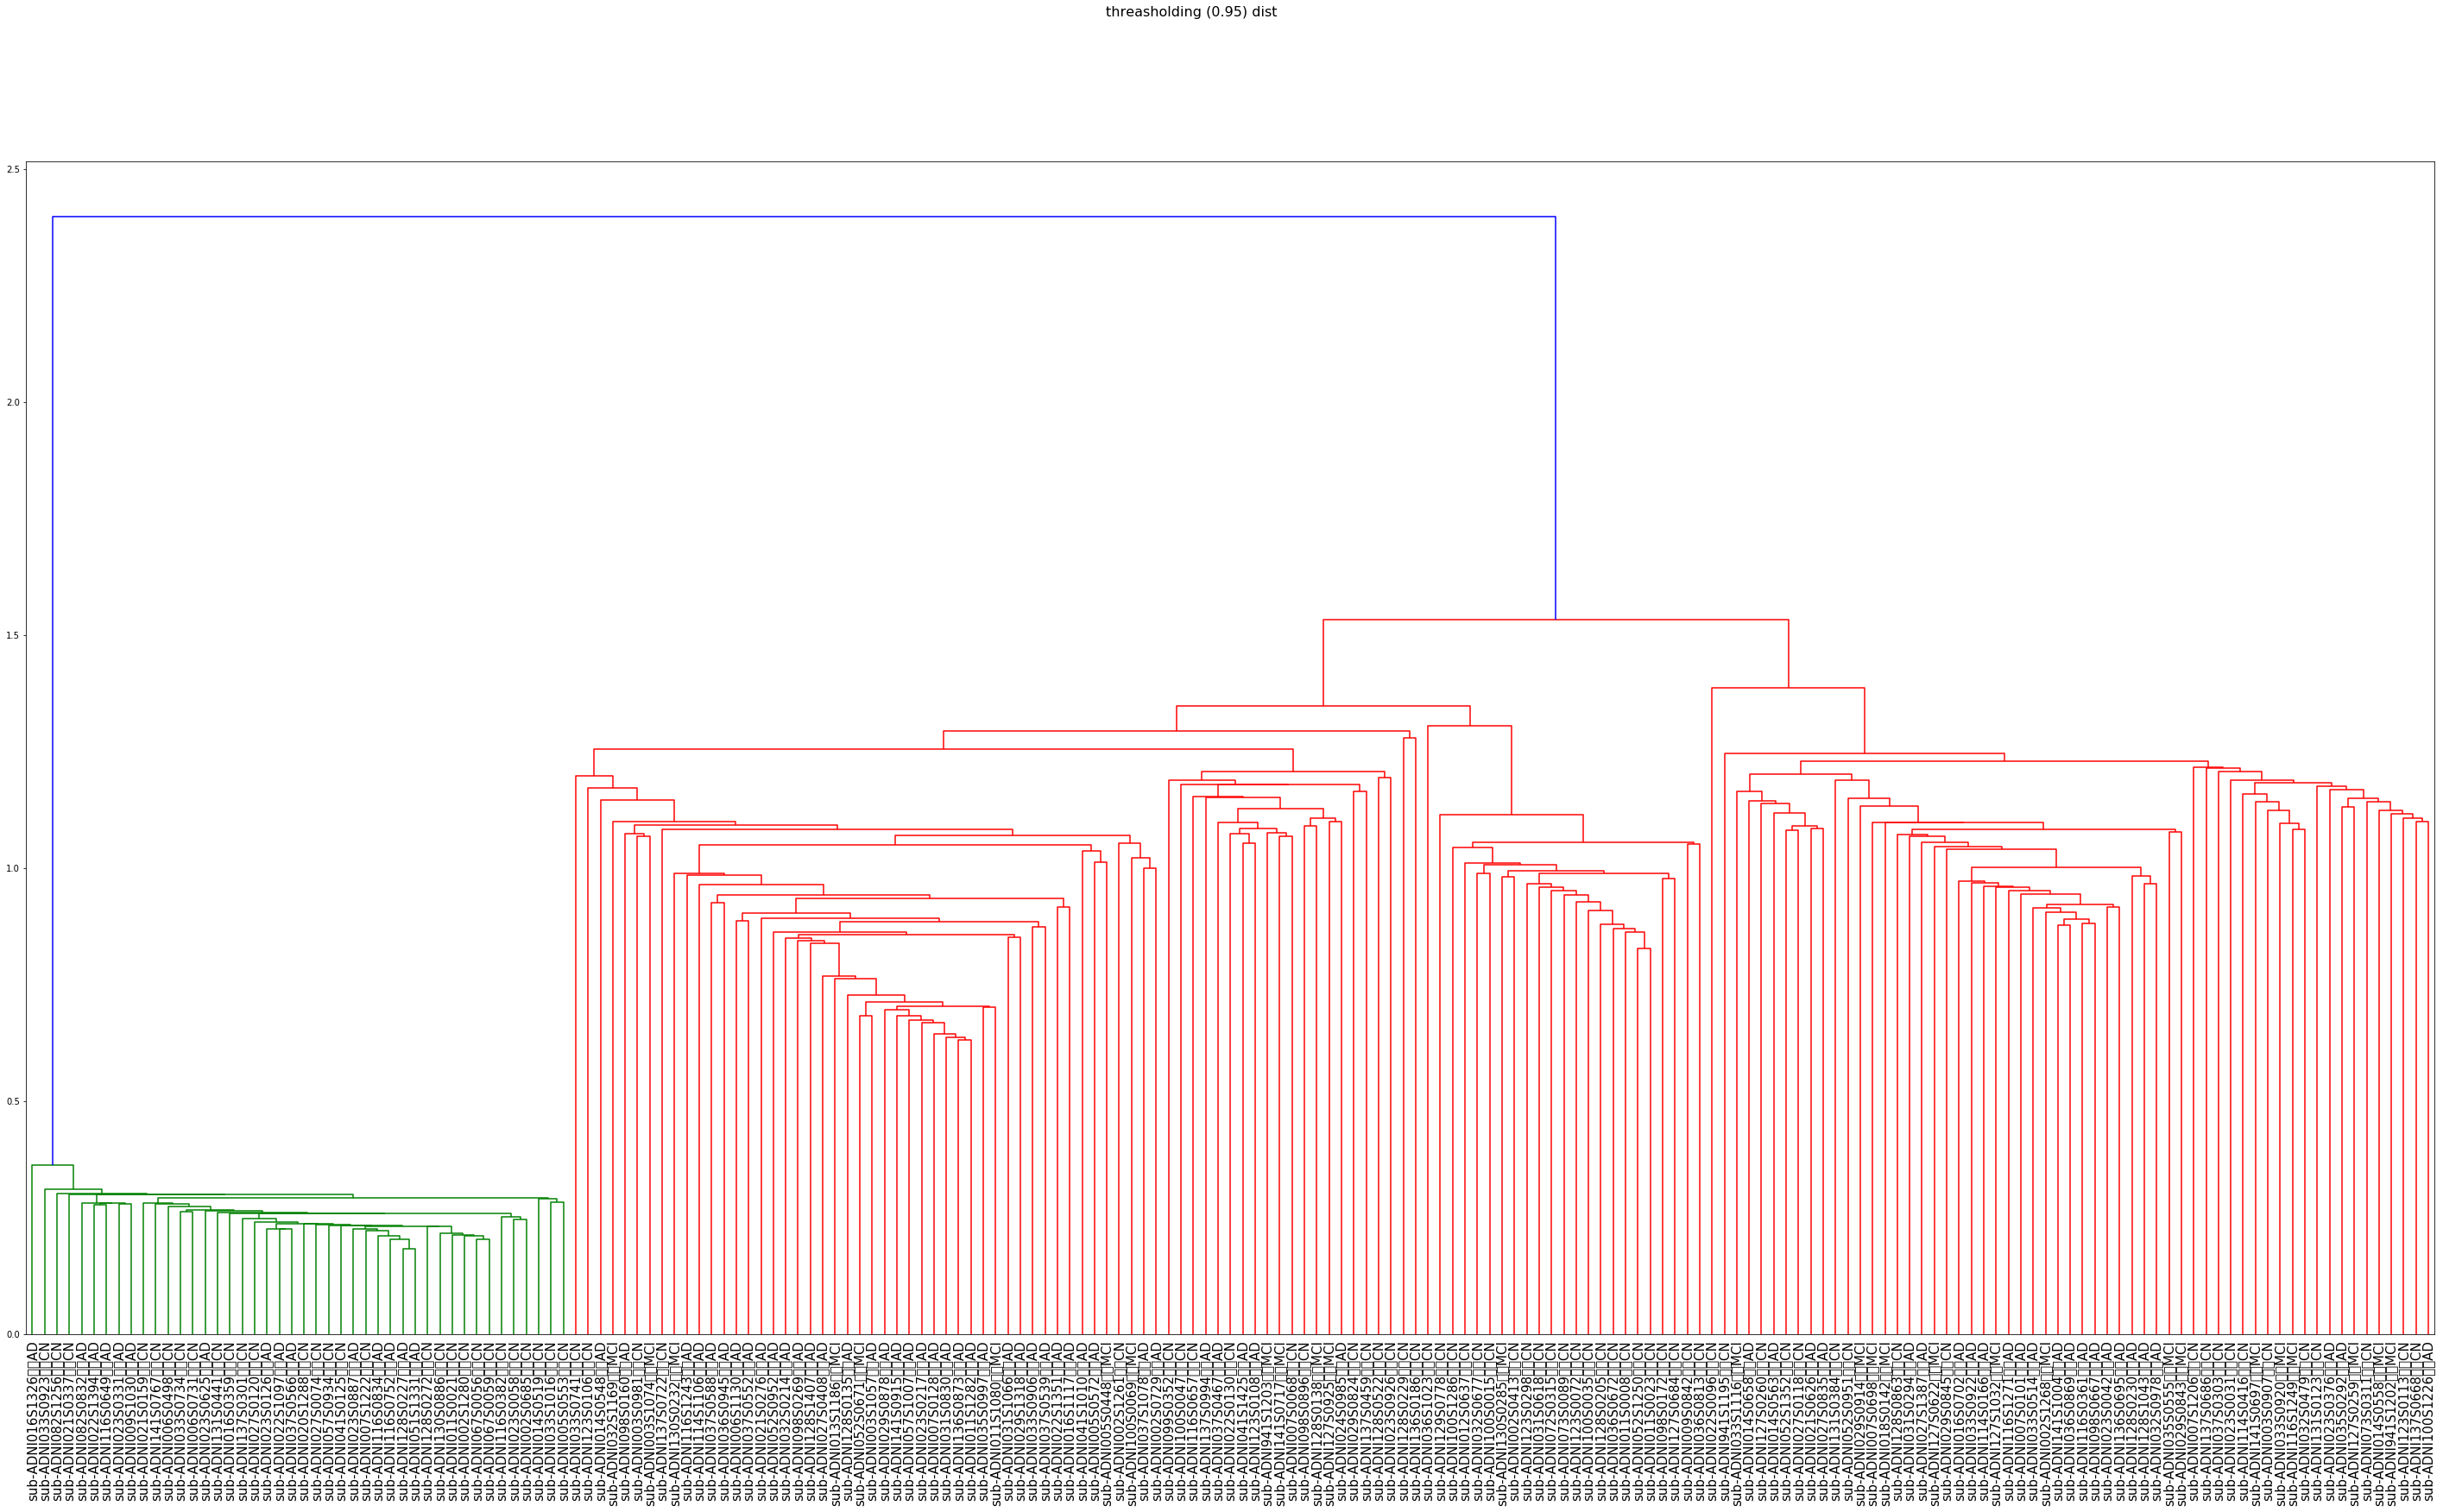

In [48]:
i, j = np.triu_indices(thres_dist.shape[0], k=1)
X = thres_dist[i, j]
labels = [df_snp_correct.participant_id.iloc[i]+'\t\t'+df_snp_correct.diagnosis_x.iloc[i] for i in range(len(df_snp_correct))]
Z = linkage(X, 'ward')
fig = plt.figure(figsize=(50, 25))
dn = dendrogram(Z, labels=labels, leaf_font_size=15)
fig.suptitle('threasholding (0.95) dist', fontsize=16)
fig.savefig('threasholding.pdf')

In [49]:
def denoisePath(path, noise_threshold=0.1):
    return join(dirname(path), basename(path).split('.npy')[0]+str(noise_threshold)+'.npy')
denoising_paths = [denoisePath(p) for p in correct_paths]

In [50]:
np.save('snp_paths.npy', correct_paths)

In [51]:
n = len(df_snp_correct)
de_dist = np.zeros((n, n))
for i in tqdm(range(n)):
    vi = np.load(denoising_paths[i]).flatten()
    for j in range(i+1, n):
        vj = np.load(denoising_paths[j]).flatten()
        de_dist[i][j] = np.linalg.norm(vi-vj)

100%|██████████| 195/195 [03:38<00:00,  1.12s/it]


In [52]:
np.save('denoise.npy', de_dist)
de_dist = np.load('denoise.npy')

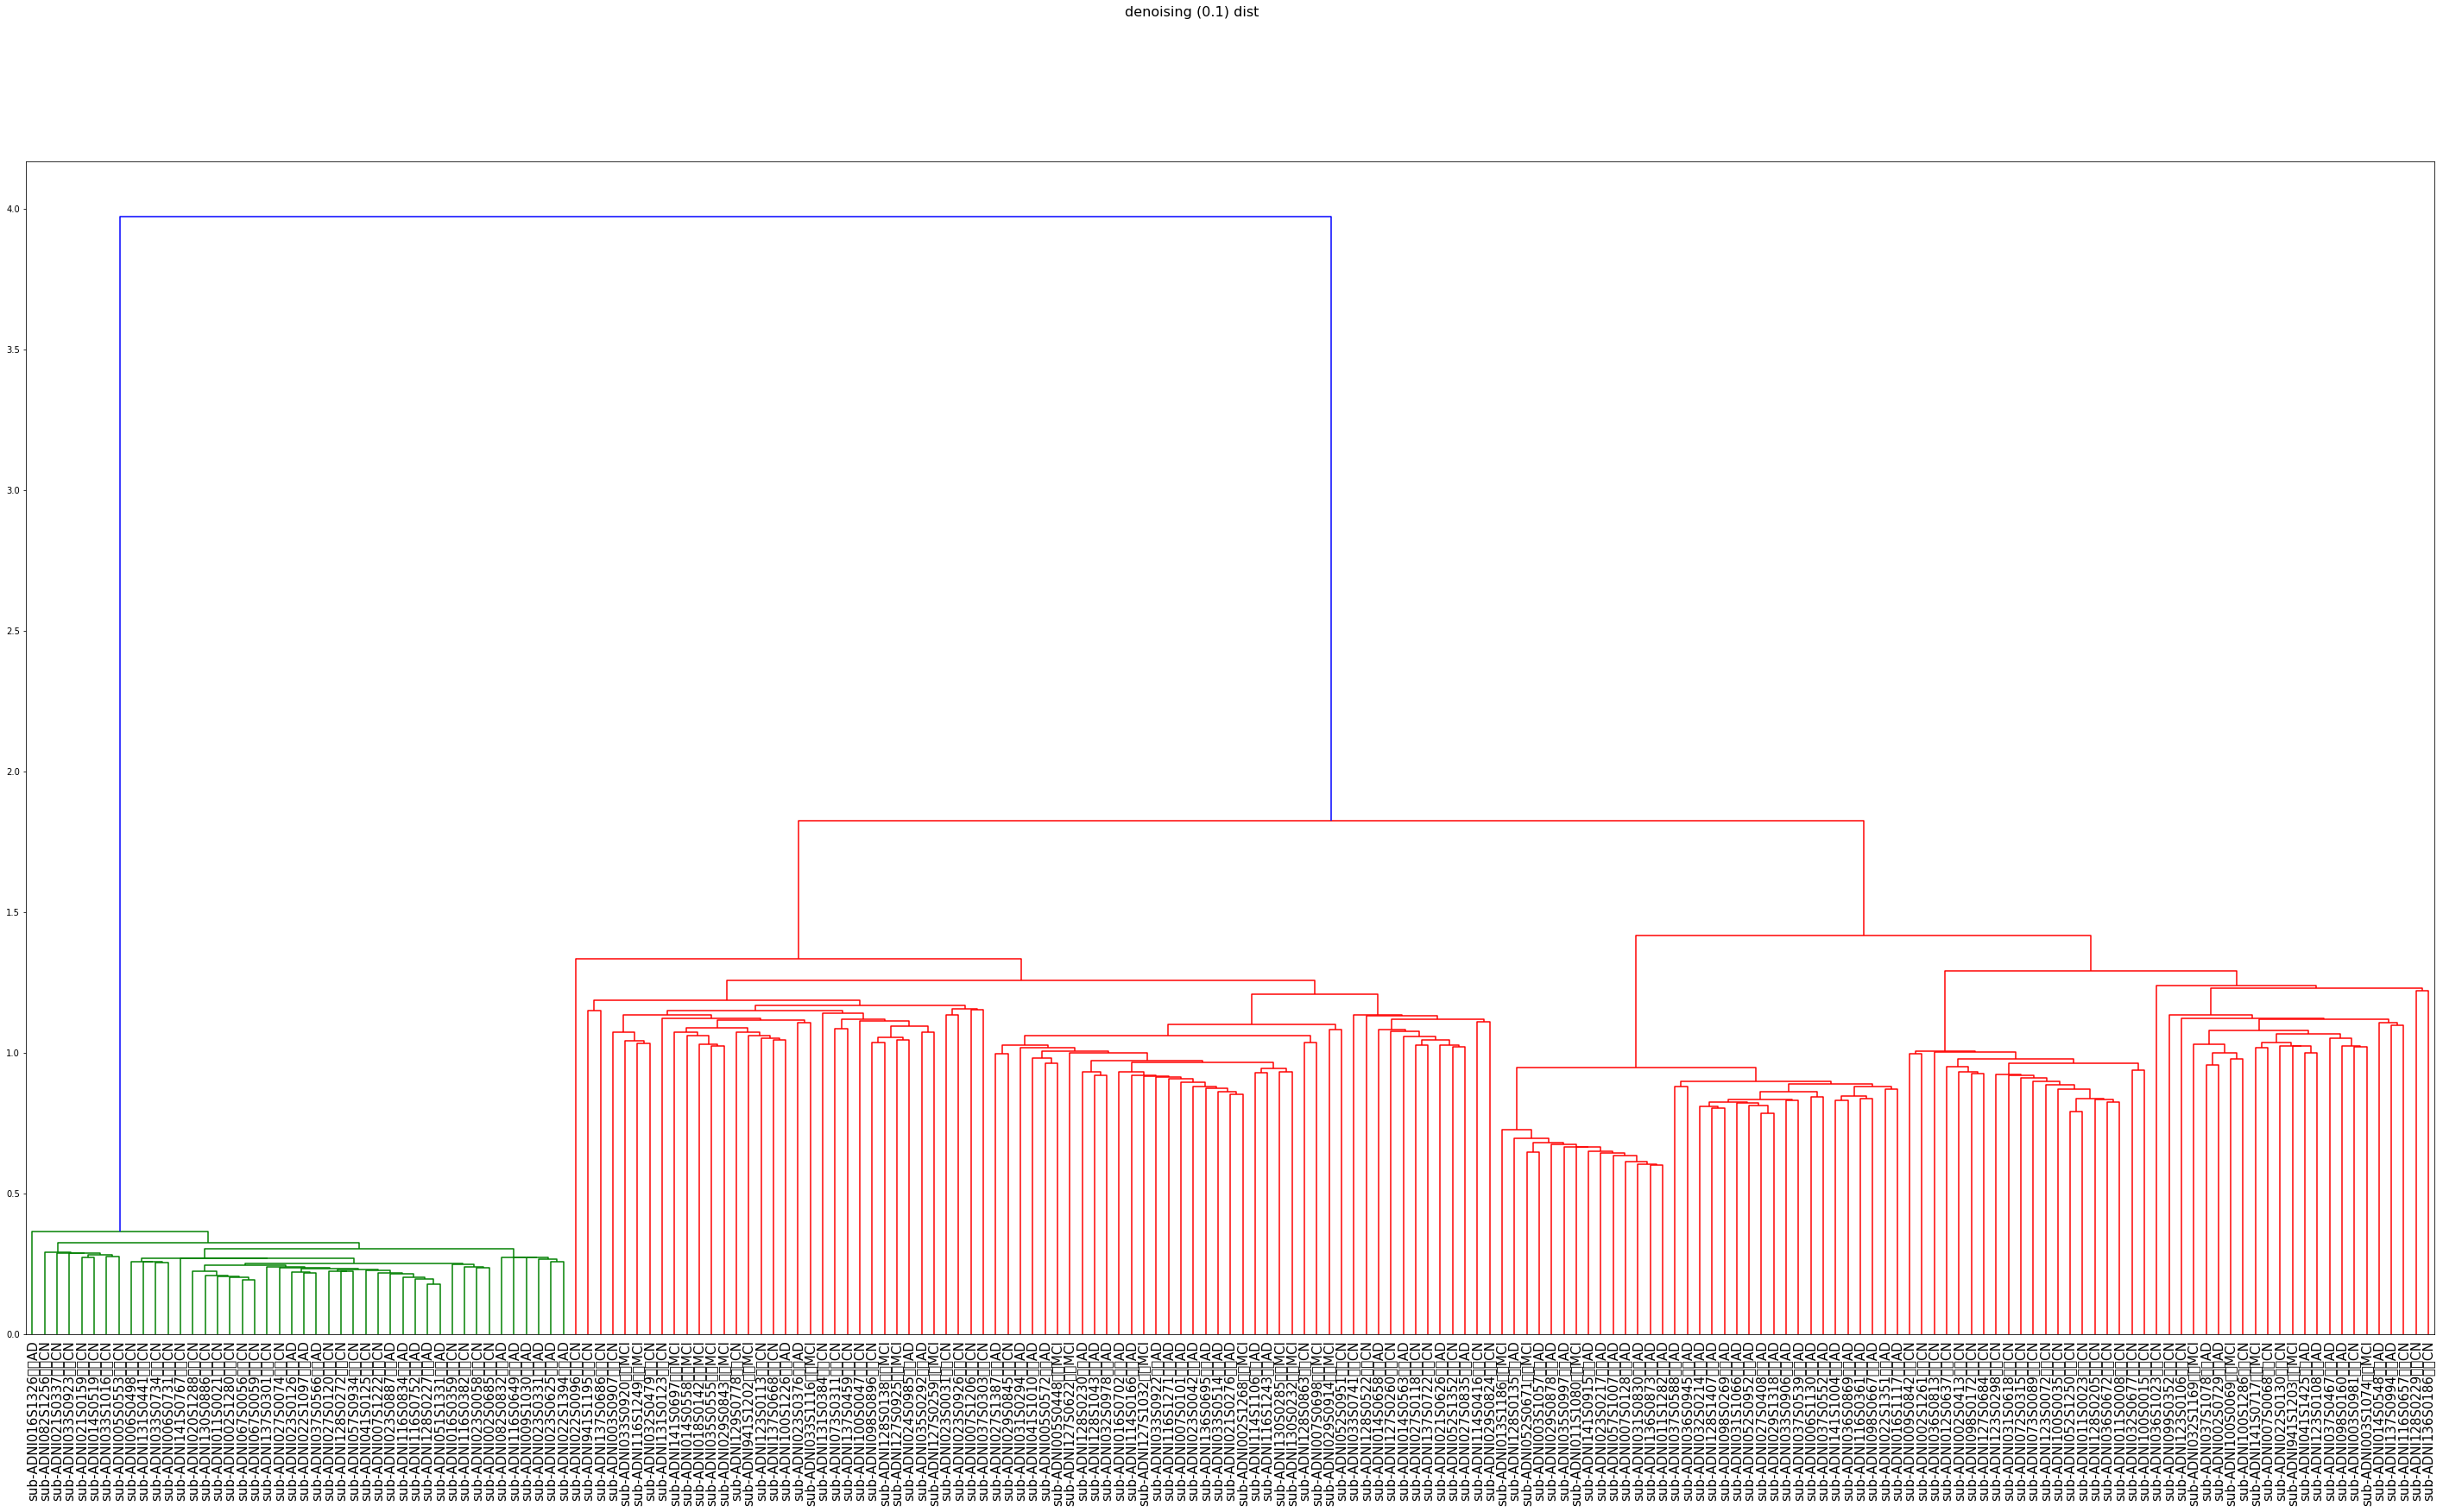

In [53]:
i, j = np.triu_indices(de_dist.shape[0], k=1)
X = de_dist[i, j]
labels = [df_snp_correct.participant_id.iloc[i]+'\t\t'+df_snp_correct.diagnosis_x.iloc[i] for i in range(len(df_snp_correct))]
Z = linkage(X, 'ward')
fig = plt.figure(figsize=(50, 25))
dn = dendrogram(Z, labels=labels, leaf_font_size=15)
fig.suptitle('denoising (0.1) dist', fontsize=16)
fig.savefig('denoising.pdf')

,participant_id,session_id,age,sex,diagnosis_x,split,diagnosis_y,prob_AD,diagnosis_pred
0,sub-ADNI021S0337,ses-M96,75.8,Male,CN,train,0,0.119849,0.0
1,sub-ADNI099S0352,ses-M96,77.0,Female,CN,train,0,0.355188,0.0
2,sub-ADNI027S0074,ses-M96,78.2,Male,CN,train,0,0.250330,0.0
3,sub-ADNI005S0610,ses-M96,79.0,Male,CN,val,0,0.595378,1.0
4,sub-ADNI035S0555,ses-M96,77.0,Male,MCI,val,1,0.655683,1.0
...,...,...,...,...,...,...,...,...,...
219,sub-ADNI033S1116,ses-M18,83.4,Male,MCI,train,1,0.699803,1.0
220,sub-ADNI127S0684,ses-M12,77.4,Female,CN,test,0,0.323724,0.0
221,sub-ADNI128S0138,ses-M12,86.3,Male,MCI,train,1,0.674724,1.0
222,sub-ADNI011S0008,ses-M06,84.5,Female,CN,test,0,0.489837,0.0


In [11]:
def df2rawpath(df, i):
    return join('ADNI_CAPS','subjects', df.participant_id.iloc[i], df.session_id.iloc[i],
                'deeplearning_prepare_data', 'image_based', 't1_linear', 
                df.participant_id.iloc[i]+'_'+df.session_id.iloc[i]+'_'+'T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt')

In [12]:
raw_paths = [df2rawpath(df_snp, i) for i in range(len(df_snp))]

In [27]:
n = len(df_snp)
input_dist = np.zeros((n, n))
for i in tqdm(range(n)):
    vi = torch.load(raw_paths[i]).squeeze().numpy().flatten()
    for j in range(i+1, n):
        vj = torch.load(raw_paths[j]).squeeze().numpy().flatten()
        input_dist[i][j] = np.linalg.norm(vi-vj)

100%|██████████| 224/224 [04:40<00:00,  1.25s/it]


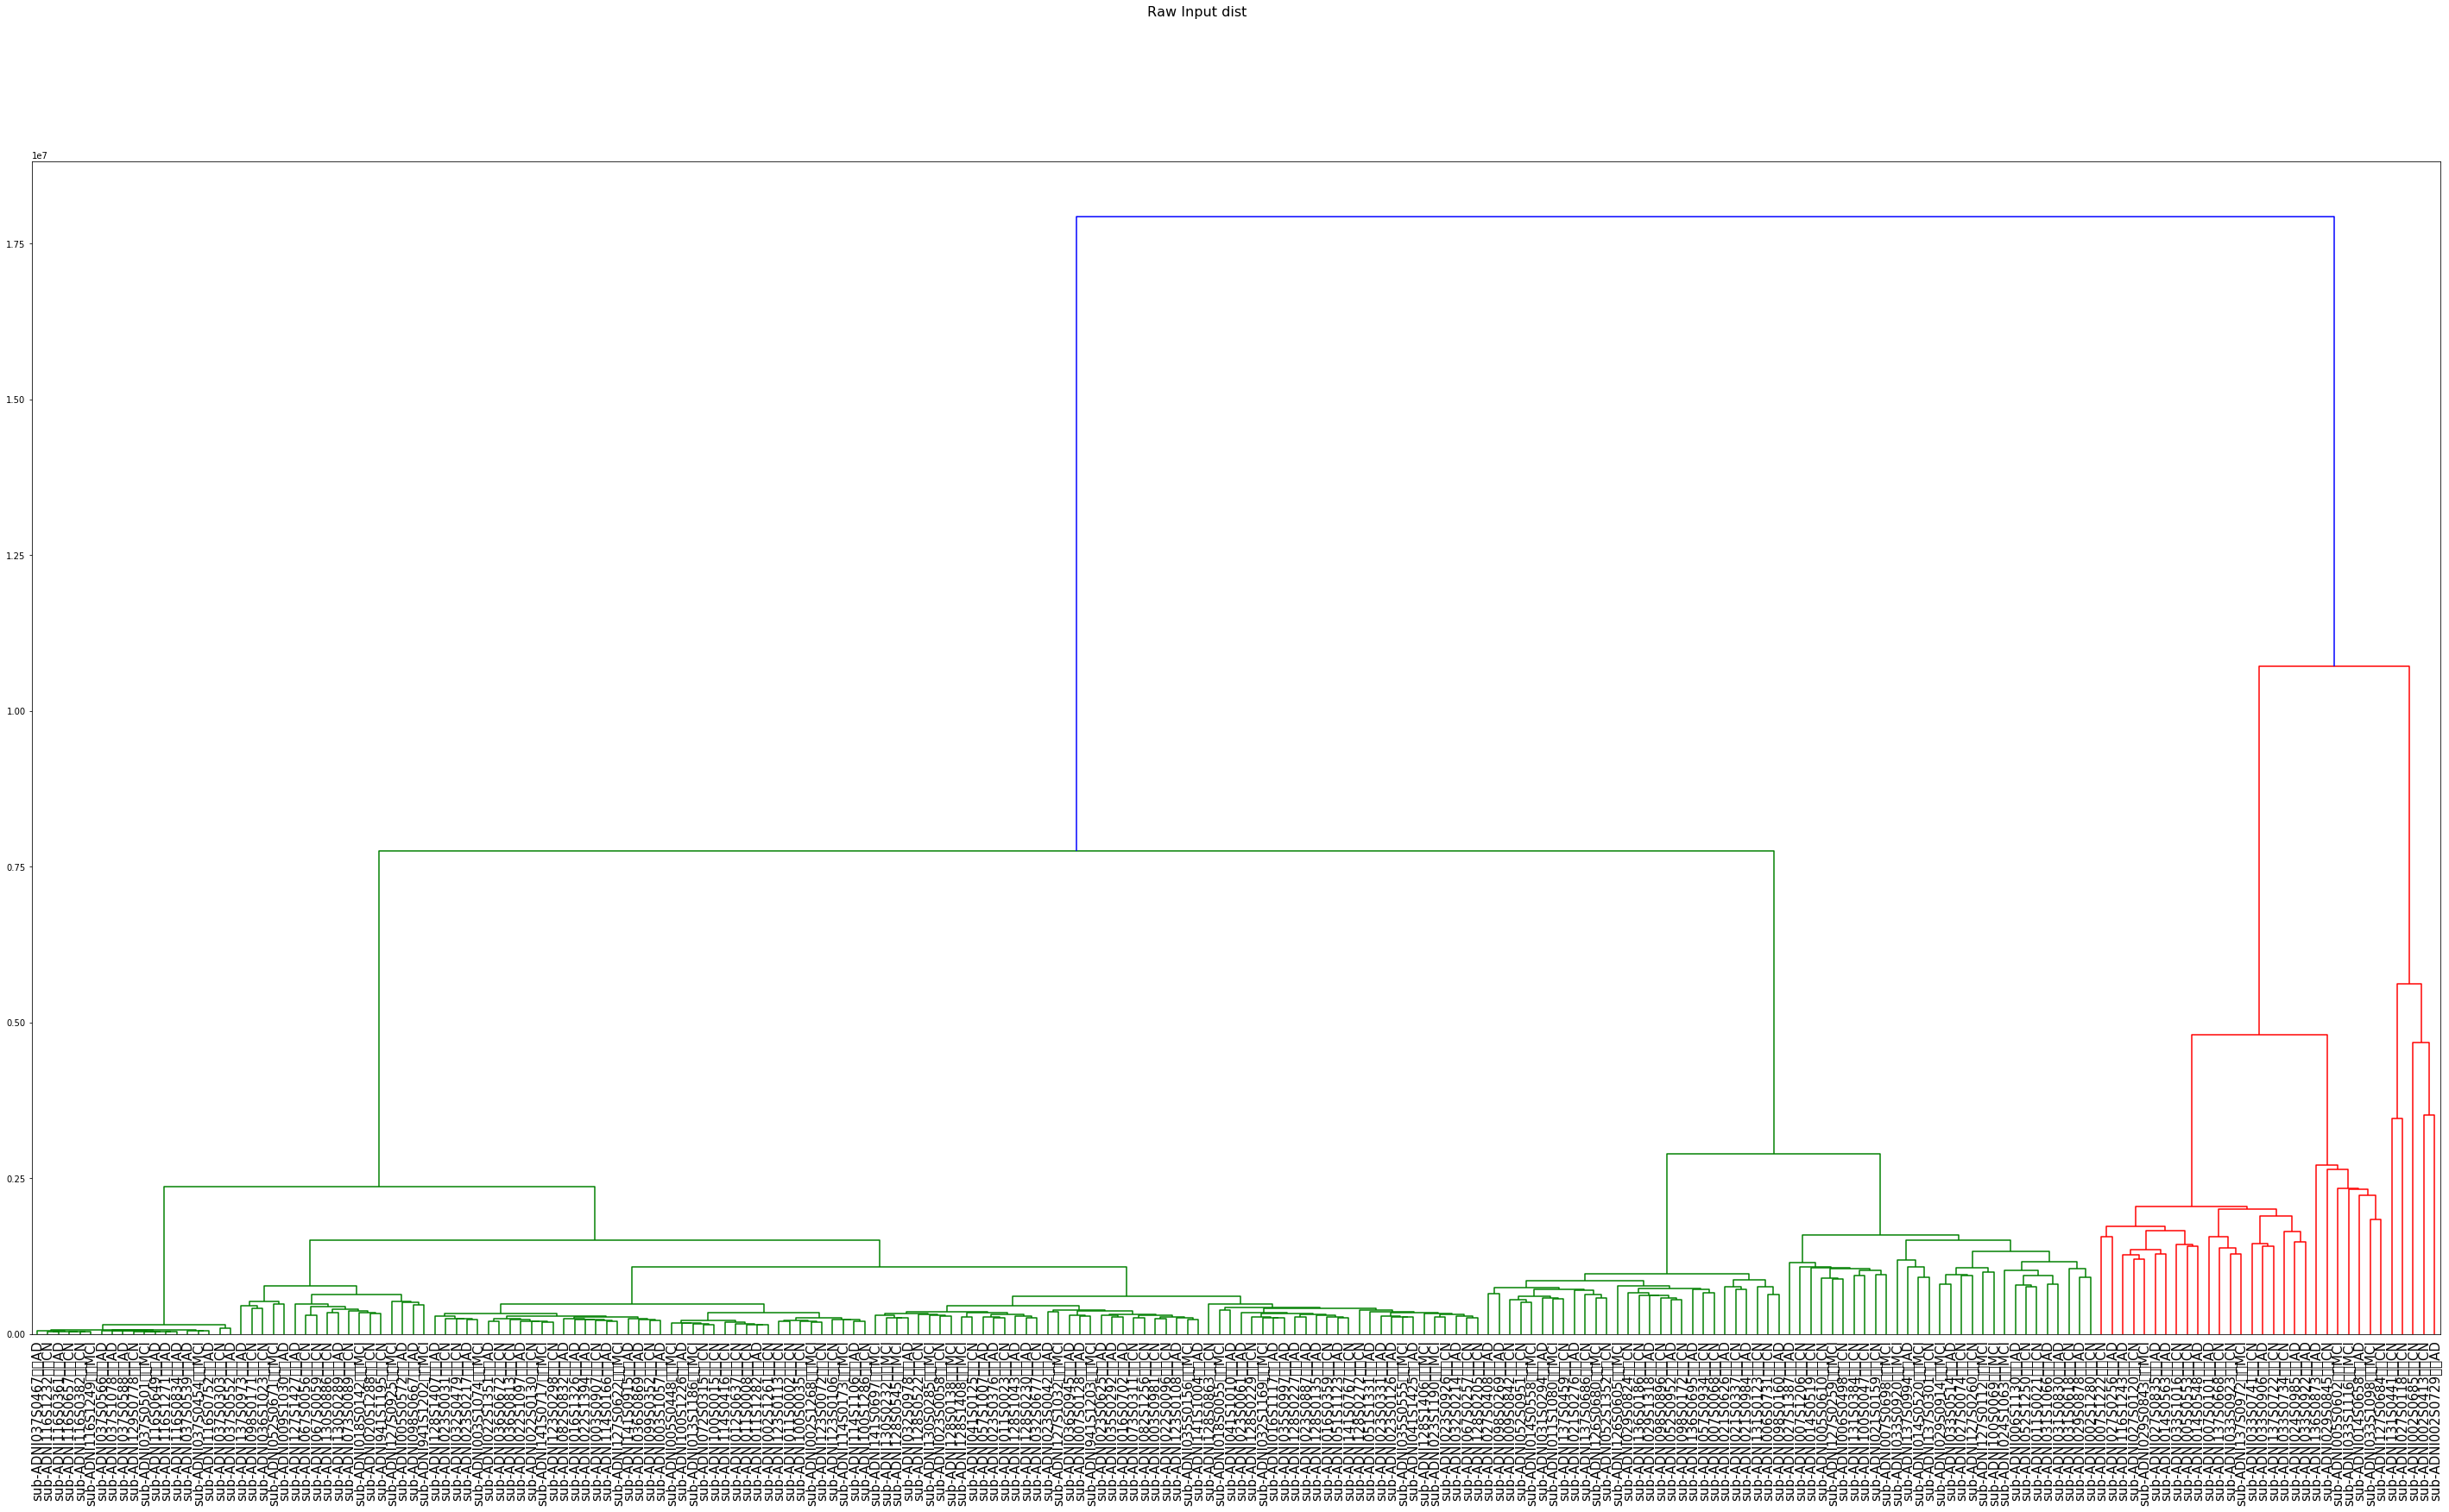

In [41]:
i, j = np.triu_indices(input_dist.shape[0], k=1)
labels = [df_snp.participant_id[i]+'\t\t'+df_snp.diagnosis_x[i] for i in range(len(df_snp))]
X = input_dist[i, j]
Z = linkage(X, 'ward')
fig = plt.figure(figsize=(50, 25))
dn = dendrogram(Z, labels=labels, leaf_font_size=15)
fig.suptitle('Raw Input dist', fontsize=16)
fig.savefig('RawInput.pdf')

In [35]:
df_snp

,participant_id,session_id,age,sex,diagnosis_x,split,diagnosis_y,prob_AD,diagnosis_pred
0,sub-ADNI021S0337,ses-M96,75.8,Male,CN,train,0,0.119849,0.0
1,sub-ADNI099S0352,ses-M96,77.0,Female,CN,train,0,0.355188,0.0
2,sub-ADNI027S0074,ses-M96,78.2,Male,CN,train,0,0.250330,0.0
3,sub-ADNI005S0610,ses-M96,79.0,Male,CN,val,0,0.595378,1.0
4,sub-ADNI035S0555,ses-M96,77.0,Male,MCI,val,1,0.655683,1.0
...,...,...,...,...,...,...,...,...,...
219,sub-ADNI033S1116,ses-M18,83.4,Male,MCI,train,1,0.699803,1.0
220,sub-ADNI127S0684,ses-M12,77.4,Female,CN,test,0,0.323724,0.0
221,sub-ADNI128S0138,ses-M12,86.3,Male,MCI,train,1,0.674724,1.0
222,sub-ADNI011S0008,ses-M06,84.5,Female,CN,test,0,0.489837,0.0
